# Distortions 2D
This notebook produces the plots for the geometric distortions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.oneway import anova_oneway

from dataframe_help import add_temperature_w0_sw

In [2]:
df = pd.read_csv('../data/distortions_df.csv', low_memory=False)
df = df[df['Method']=='UNetAxis']
df.drop(df[(df['Subject'] == 'P0020') & (df['Session'] == '20240419161029')].index, inplace=True)

# Cor flip x
# Sag flip y
# Axi flip z
df.loc[df['Axis'] == 'cor', 'x_reg'] *= -1
df.loc[df['Axis'] == 'sag', 'y_reg'] *= -1

df.x_diff = df.x_ref - df.x_reg
df.y_diff = df.y_ref - df.y_reg
df.z_diff = df.z_ref - df.z_reg

df['abs_x_diff'] = df.x_diff.abs()
df['abs_y_diff'] = df.y_diff.abs()
df['abs_z_diff'] = df.z_diff.abs()

df['MagDiff'] = np.sqrt(df['x_diff']**2 + df['y_diff']**2 + df['z_diff']**2)
df['LabelValue'] = df['LabelValue'].astype(int)

In [3]:
df_scale = pd.read_csv('../data/distortions_scale_df.csv')
df_scale['S'] = df_scale['S'].abs()
df_scale['rxy'] = df_scale['rxy'].abs()

df_scale = add_temperature_w0_sw(df_scale, '../data')
df = add_temperature_w0_sw(df, '../data')

Adding in temperature, w0 and SW: 100%|██████████| 10884/10884 [00:06<00:00, 1767.26it/s]


## Deviations from true positions in-plane for all orientations

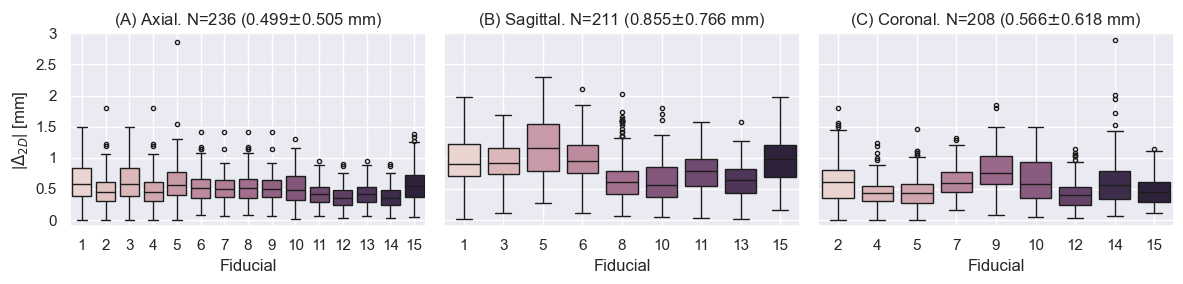

axi Mean: 0.499 SD: 0.505
sag Mean: 0.855 SD: 0.766
cor Mean: 0.566 SD: 0.618


In [4]:
sns.set_theme()
fig, axes = plt.subplots(1,3,figsize=(12,3))

titles = ['(A) Axial', '(B) Sagittal', '(C) Coronal']
for i,scan_ax in enumerate(['axi', 'sag', 'cor']):
    sns.boxplot(data=df[(df['Axis']==scan_ax) & (df['Run']==1)], y='MagDiff', 
                x='LabelValue',  hue='LabelValue', legend=None, ax=axes[i], flierprops={"marker": "."})

    axes[i].set_ylim([-.5,3])
    nscans = df[(df['Axis']==scan_ax) & (df['Run']==1)].Session.unique().shape[-1]
    mean_diff = df[(df['Axis']==scan_ax) & (df['Run']==1)].MagDiff.mean()
    sd_diff = df[(df['Axis']==scan_ax) & (df['Run']==1)].MagDiff.std()
    axes[i].set_title(rf"{titles[i]}. N={nscans} ({mean_diff:.3f}$\pm${1.96*sd_diff:.3f} mm)")

    if i>0:
        axes[i].set_ylabel(None)
        axes[i].set_yticks([0,.5,1,1.5,2,2.5,3], [])
    else:
        axes[i].set_yticks([0,.5,1,1.5,2,2.5,3], [0,.5,1,1.5,2,2.5,3])

axes[0].set_ylabel(r'|$\Delta_{2D}$| [mm]')

for ax in axes:
    ax.grid('minor')
    ax.set_ylim([-.1,3])
    ax.set_xlabel('Fiducial')

plt.tight_layout()
plt.savefig('../results/figure10a_Distortions_axis.png', dpi=300)
plt.show()

for i,scan_ax in enumerate(['axi', 'sag', 'cor']):
    my_data = df[(df['Axis']==scan_ax) & (df['Run']==1)]
    m = my_data.MagDiff.mean()
    s = my_data.MagDiff.std()
    print(f"{scan_ax} Mean: {m:.3} SD: {1.96*s:.3}")

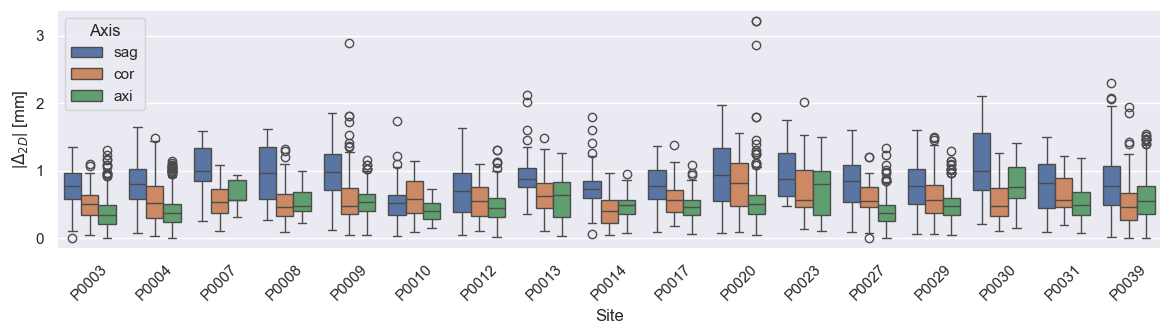

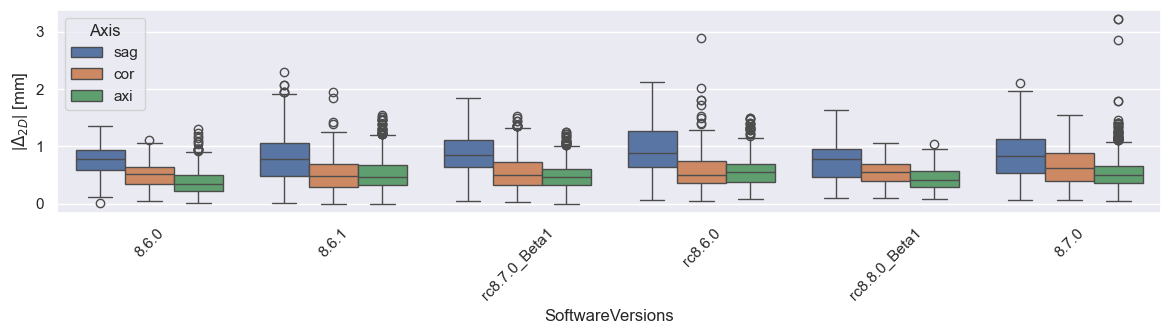

In [5]:
sns.set_theme()

fig, ax = plt.subplots(1,1,figsize=(12,3.5))
sns.boxplot(data=df, x='Subject', y='MagDiff', hue='Axis', ax=ax)
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel(r'|$\Delta_{2D}$| [mm]')
ax.set_xlabel('Site')
plt.tight_layout()
plt.savefig('../results/figure10b_Distortion_sites.png', dpi=300)
plt.show()

fig, ax = plt.subplots(1,1,figsize=(12,3.5))
sns.boxplot(data=df, x='SoftwareVersions', y='MagDiff', hue='Axis', ax=ax)
ax.set_ylabel(r'|$\Delta_{2D}$| [mm]')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [6]:
# Check which factors that influence the magnitude distortion
for axis in ['axi', 'cor', 'sag']:
    print(f"------------ {axis} ------------")
    my_df = df[(df['Axis']==axis)]
    formula = 'MagDiff ~ Temperature + C(SoftwareVersions) + C(Subject)'
    model = smf.ols(formula, data=my_df).fit()
    anova_results = sm.stats.anova_lm(model, typ=2)

    print(anova_results)

------------ axi ------------
                         sum_sq      df          F         PR(>F)
C(SoftwareVersions)   13.354767     5.0  47.906112   6.695113e-49
C(Subject)            46.064056    16.0  51.637688  4.027448e-156
Temperature            1.235762     1.0  22.164585   2.550137e-06
Residual             394.347470  7073.0        NaN            NaN
------------ cor ------------
                         sum_sq      df         F        PR(>F)
C(SoftwareVersions)    1.847985     5.0  3.972010  1.379818e-03
C(Subject)            10.316699    16.0  6.929514  1.031309e-15
Temperature            0.295724     1.0  3.178107  7.479428e-02
Residual             172.980583  1859.0       NaN           NaN
------------ sag ------------
                         sum_sq      df         F        PR(>F)
C(SoftwareVersions)    2.100628     5.0  2.931263  1.215915e-02
C(Subject)            18.668866    16.0  8.140921  3.174729e-19
Temperature            0.241754     1.0  1.686744  1.941895e-01
Resi

## Scale and shear

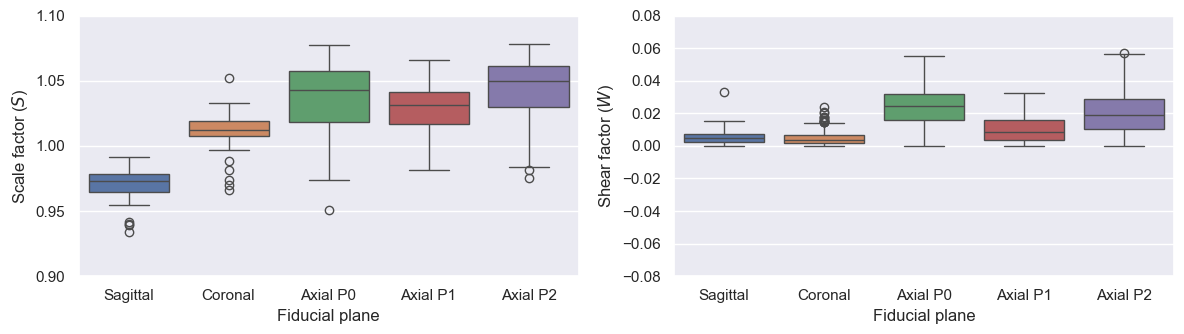

In [7]:
df_scale['new_axis'] = df_scale['Axis'].astype(str) + df_scale['Plate'].astype(str)
df_scale['nice_axis'] = ''
df_scale.loc[df_scale['new_axis']=='axi0', 'nice_axis'] = 'Axial P0'
df_scale.loc[df_scale['new_axis']=='axi1', 'nice_axis'] = 'Axial P1'
df_scale.loc[df_scale['new_axis']=='axi2', 'nice_axis'] = 'Axial P2'
df_scale.loc[df_scale['new_axis']=='sag0', 'nice_axis'] = 'Sagittal'
df_scale.loc[df_scale['new_axis']=='cor0', 'nice_axis'] = 'Coronal'

sw_order = ['rc8.6.0', '8.6.0', '8.6.1', 'rc8.7.0_Beta1', '8.7.0', 'rc8.8.0_Beta1']

gs = gridspec.GridSpec(1,2, width_ratios=[1,1])
fig = plt.figure(figsize=(12,3.5))

ax = fig.add_subplot(gs[0,0])
sns.boxplot(df_scale, y='S', x='nice_axis', hue='new_axis', ax=ax, legend=None)
ax.set_ylim([0.9, 1.1])
ax.set_ylabel('Scale factor ($S$)')
ax.set_xlabel('Fiducial plane')

ax = fig.add_subplot(gs[0,1])
sns.boxplot(df_scale, y='rxy', x='nice_axis', hue='new_axis', ax=ax, legend=None)
ax.set_ylim([-.08, .08])
ax.set_ylabel('Shear factor ($W$)')
ax.set_xlabel('Fiducial plane')

plt.tight_layout()
plt.savefig('../results/figure9_scale_shear.png', dpi=300)
plt.show()

In [8]:
# Look at shearing and if it is different from 0

data = df_scale[df_scale.Axis=='cor'].rxy
print(f"Coronal \t Mean={data.mean():.5f} CI={np.array([-1,1])*1.96*data.std() + data.mean()}")

data = df_scale[df_scale.Axis=='sag'].rxy
print(f"Sag \t\t Mean={data.mean():.5f} CI={np.array([-1,1])*1.96*data.std() + data.mean()}")

data = df_scale[(df_scale.Axis=='axi') & (df_scale.Plate==1)].rxy
print(f"Axial P1 \t Mean={data.mean():.5f} CI={np.array([-1,1])*1.96*data.std() + data.mean()}")

data = df_scale[(df_scale.Axis=='axi') & (df_scale.Plate==0)].rxy
print(f"Axial P0 \t Mean={data.mean():.5f} CI={np.array([-1,1])*1.96*data.std() + data.mean()}")

data = df_scale[(df_scale.Axis=='axi') & (df_scale.Plate==2)].rxy
print(f"Axial P2 \t Mean={data.mean():.5f} CI={np.array([-1,1])*1.96*data.std() + data.mean()}")

Coronal 	 Mean=0.00485 CI=[-0.00399345  0.01370262]
Sag 		 Mean=0.00521 CI=[-0.00287815  0.01328918]
Axial P1 	 Mean=0.00960 CI=[-0.0036612   0.02286592]
Axial P0 	 Mean=0.02365 CI=[0.00238329 0.04492368]
Axial P2 	 Mean=0.01957 CI=[-0.00403305  0.04317039]


In [9]:
# Check anova
anova_data = df_scale['S']
groups = df_scale['Axis']
res = anova_oneway(anova_data, groups)
print(f"ANOVA p-value for difference between axes: {res.pvalue:.2e}")

new_df = df_scale[df_scale.Axis=='axi']
anova_data = new_df['S']
groups = new_df['Plate']
res = anova_oneway(anova_data, groups)
print(f"ANOVA p-value for difference between plates on axial: {res.pvalue:.2e}")

ANOVA p-value for difference between axes: 4.30e-280
ANOVA p-value for difference between plates on axial: 2.20e-28


In [10]:
for k in ['S', 'rxy']:
    print(f"----------- {k} axi -----------")
    my_df = df_scale[df_scale.Axis=='axi'].copy()

    formula = f'{k} ~ C(Plate) + C(SoftwareVersions) + C(Subject)'
    model = smf.ols(formula, data=my_df).fit()

    anova_results = sm.stats.anova_lm(model, typ=2)

    print(anova_results)

----------- S axi -----------
                           sum_sq      df           F         PR(>F)
C(Plate)             5.028404e-02     2.0  312.616076  6.455289e-113
C(SoftwareVersions)  8.921750e-07     5.0    0.002219   9.624381e-01
C(Subject)           2.854960e-06    16.0    0.002219   9.624381e-01
Residual             1.122727e-01  1396.0         NaN            NaN
----------- rxy axi -----------
                       sum_sq      df           F         PR(>F)
C(Plate)             0.049331     2.0  349.706290  7.653821e-124
C(SoftwareVersions)  0.000428     5.0    1.214639   2.706054e-01
C(Subject)           0.001371    16.0    1.214639   2.706054e-01
Residual             0.098463  1396.0         NaN            NaN


/Users/emil/miniforge3/envs/qa_paper/lib/python3.9/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/emil/miniforge3/envs/qa_paper/lib/python3.9/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/emil/miniforge3/envs/qa_paper/lib/python3.9/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/emil/miniforge3/envs/qa_paper/lib/python3.9/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constra

In [11]:
for ax in ['sag', 'cor']:
    for k in ['S', 'rxy']:
        print(f"----------- {k} {ax} -----------")
        my_df = df_scale[df_scale.Axis=='sag'].copy()

        formula = f'{k} ~ C(SoftwareVersions) + C(Subject)'
        model = smf.ols(formula, data=my_df).fit()

        anova_results = sm.stats.anova_lm(model, typ=2)

        print(anova_results)

    print('\n')

----------- S sag -----------
                       sum_sq     df          F        PR(>F)
C(SoftwareVersions)  0.005546    5.0  57.202942  3.673027e-36
C(Subject)           0.010805   16.0  34.826923  5.819636e-48
Residual             0.003703  191.0        NaN           NaN
----------- rxy sag -----------
                       sum_sq     df         F    PR(>F)
C(SoftwareVersions)  0.000172    5.0  2.541810  0.029701
C(Subject)           0.000737   16.0  3.412232  0.000025
Residual             0.002580  191.0       NaN       NaN


----------- S cor -----------
                       sum_sq     df          F        PR(>F)
C(SoftwareVersions)  0.005546    5.0  57.202942  3.673027e-36
C(Subject)           0.010805   16.0  34.826923  5.819636e-48
Residual             0.003703  191.0        NaN           NaN
----------- rxy cor -----------
                       sum_sq     df         F    PR(>F)
C(SoftwareVersions)  0.000172    5.0  2.541810  0.029701
C(Subject)           0.000737   16.0

In [12]:
# Check anova
new_df = pd.concat([df_scale[(df_scale.Axis=='axi') & (df_scale.Plate==1)], df_scale[df_scale.Axis.isin(['sag', 'cor'])]])
anova_data = new_df['rxy']
groups = new_df['Axis']
res = anova_oneway(anova_data, groups)
print(f"ANOVA for difference in shear between scan axes looking only at the central plane\np={res.pvalue:.2e}")

ANOVA for difference in shear between scan axes looking only at the central plane
p=5.55e-29


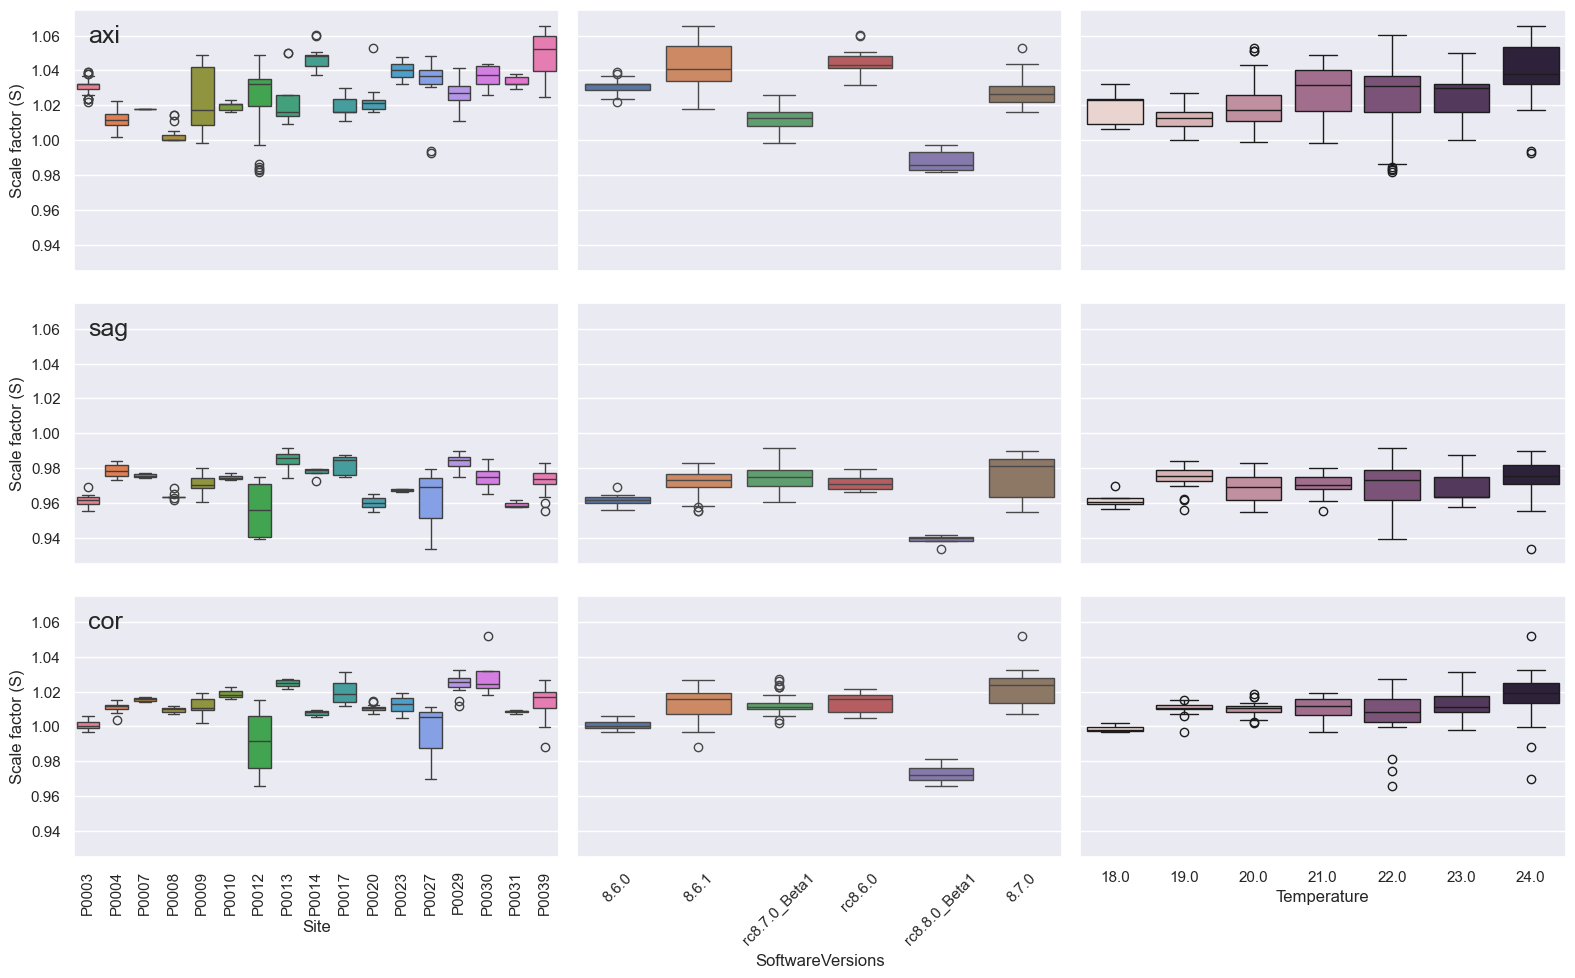

In [13]:
fig, axes = plt.subplots(3,3, figsize=(16,10))

for i,scan_ax in enumerate(['axi', 'sag', 'cor']):
    axes[i,0].text(0,1.06, scan_ax, verticalalignment='center', fontsize=18, horizontalalignment='left')

    plate = 1 if scan_ax=='axi' else 0
    my_filt = (df_scale.Axis==scan_ax) & (df_scale.Plate==plate)
    sns.boxplot(df_scale[my_filt], y='S', x='Subject', hue='Subject', ax=axes[i,0], legend=None)
    sns.boxplot(df_scale[my_filt], y='S', x='SoftwareVersions', hue='SoftwareVersions', ax=axes[i,1], legend=False)
    sns.boxplot(df_scale[my_filt], y='S', x='Temperature', hue='Temperature', ax=axes[i,2], legend=None)

    axes[i,1].set_ylabel(None)
    axes[i,2].set_ylabel(None)
    axes[i,1].set_yticklabels([])
    axes[i,2].set_yticklabels([])

    axes[i,0].tick_params(axis='x', rotation=90)
    axes[i,1].tick_params(axis='x', rotation=45)


    for ax in axes[i,:]:
        ax.set_ylim([.925, 1.075])

        if i<2:
            ax.set_xlabel(None)
            ax.set_xticklabels([])

    axes[i,0].set_ylabel('Scale factor (S)')

axes[2,0].set_xlabel('Site')

plt.tight_layout()
plt.show()

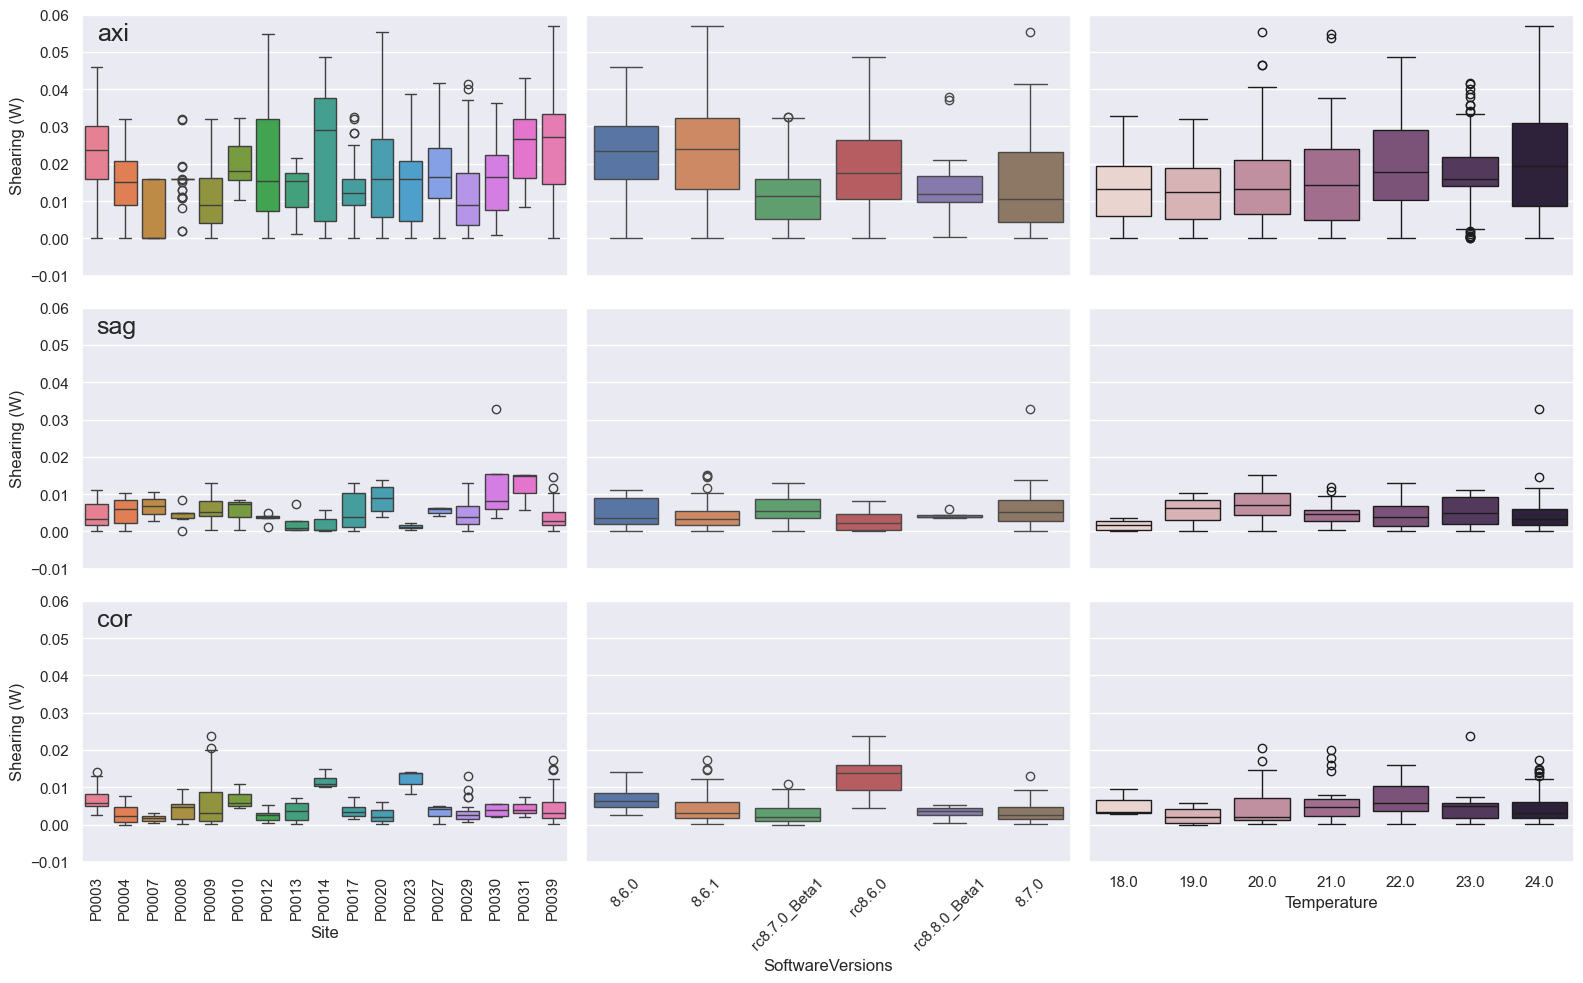

In [14]:
fig, axes = plt.subplots(3,3, figsize=(16,10))

for i,scan_ax in enumerate(['axi', 'sag', 'cor']):
    axes[i,0].text(0,0.055, scan_ax, verticalalignment='center', fontsize=18, horizontalalignment='left')

    sns.boxplot(df_scale[df_scale.Axis==scan_ax], y='rxy', x='Subject', hue='Subject', ax=axes[i,0], legend=None)
    sns.boxplot(df_scale[df_scale.Axis==scan_ax], y='rxy', x='SoftwareVersions', hue='SoftwareVersions', ax=axes[i,1], legend=False)
    sns.boxplot(df_scale[df_scale.Axis==scan_ax], y='rxy', x='Temperature', hue='Temperature', ax=axes[i,2], legend=None)

    axes[i,1].set_ylabel(None)
    axes[i,2].set_ylabel(None)
    axes[i,1].set_yticklabels([])
    axes[i,2].set_yticklabels([])

    axes[i,0].tick_params(axis='x', rotation=90)
    axes[i,1].tick_params(axis='x', rotation=45)

    for ax in axes[i,:]:
        ax.set_ylim([-.01, .06])

        if i<2:
            ax.set_xlabel(None)
            ax.set_xticklabels([])

    axes[i,0].set_ylabel('Shearing (W)')

axes[2,0].set_xlabel('Site')



plt.tight_layout()
plt.show()

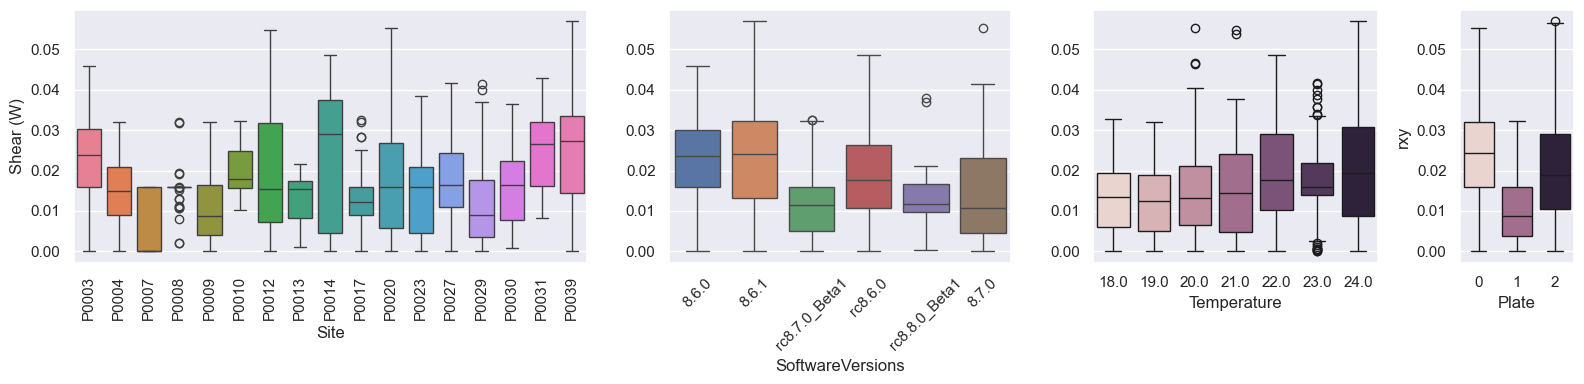

In [15]:
gs = gridspec.GridSpec(1,4,width_ratios=[18,12,10,4])
fig = plt.figure(figsize=(16,4))

axes = []
for i in range(4):
    ax = fig.add_subplot(gs[i])
    axes.append(ax)

sns.boxplot(df_scale[df_scale.Axis=='axi'], y='rxy', x='Subject', hue='Subject', ax=axes[0], legend=None)
sns.boxplot(df_scale[df_scale.Axis=='axi'], y='rxy', x='SoftwareVersions', hue='SoftwareVersions', ax=axes[1], legend=False)
sns.boxplot(df_scale[df_scale.Axis=='axi'], y='rxy', x='Temperature', hue='Temperature', ax=axes[2], legend=None)
sns.boxplot(df_scale[df_scale.Axis=='axi'], y='rxy', x='Plate', hue='Plate', ax=axes[3], legend=None)

axes[1].set_ylabel(None)
axes[2].set_ylabel(None)

axes[0].tick_params(axis='x', rotation=90)
axes[1].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('Site')
axes[0].set_ylabel('Shear (W)')

plt.tight_layout()
plt.show()

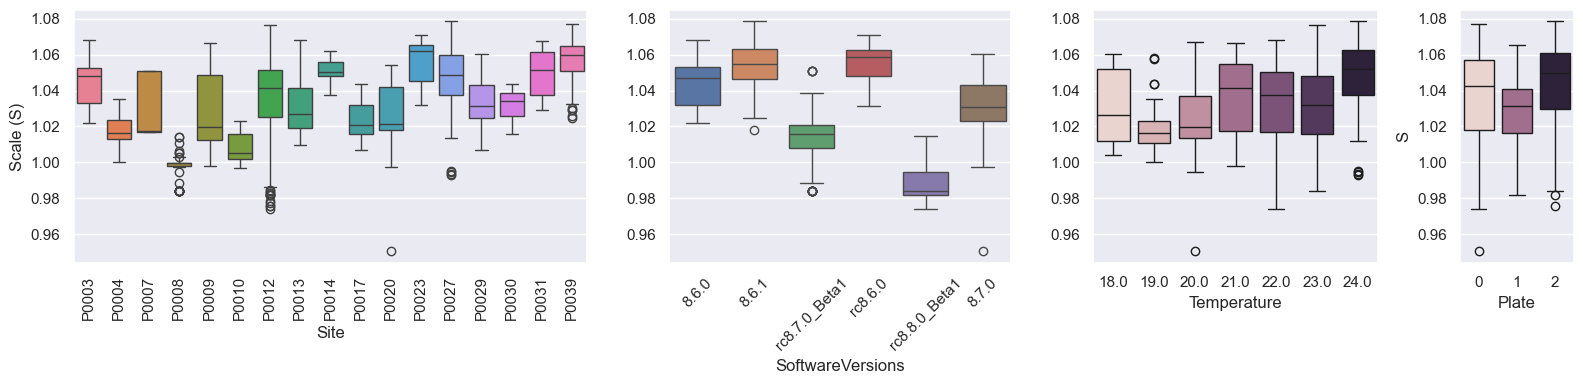

In [16]:
gs = gridspec.GridSpec(1,4,width_ratios=[18,12,10,4])
fig = plt.figure(figsize=(16,4))

axes = []
for i in range(4):
    ax = fig.add_subplot(gs[i])
    axes.append(ax)

sns.boxplot(df_scale[df_scale.Axis=='axi'], y='S', x='Subject', hue='Subject', ax=axes[0], legend=None)
sns.boxplot(df_scale[df_scale.Axis=='axi'], y='S', x='SoftwareVersions', hue='SoftwareVersions', ax=axes[1], legend=False)
sns.boxplot(df_scale[df_scale.Axis=='axi'], y='S', x='Temperature', hue='Temperature', ax=axes[2], legend=None)
sns.boxplot(df_scale[df_scale.Axis=='axi'], y='S', x='Plate', hue='Plate', ax=axes[3], legend=None)

axes[1].set_ylabel(None)
axes[2].set_ylabel(None)

axes[0].tick_params(axis='x', rotation=90)
axes[1].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('Site')
axes[0].set_ylabel('Scale (S)')

plt.tight_layout()
plt.show()

# Additional figures

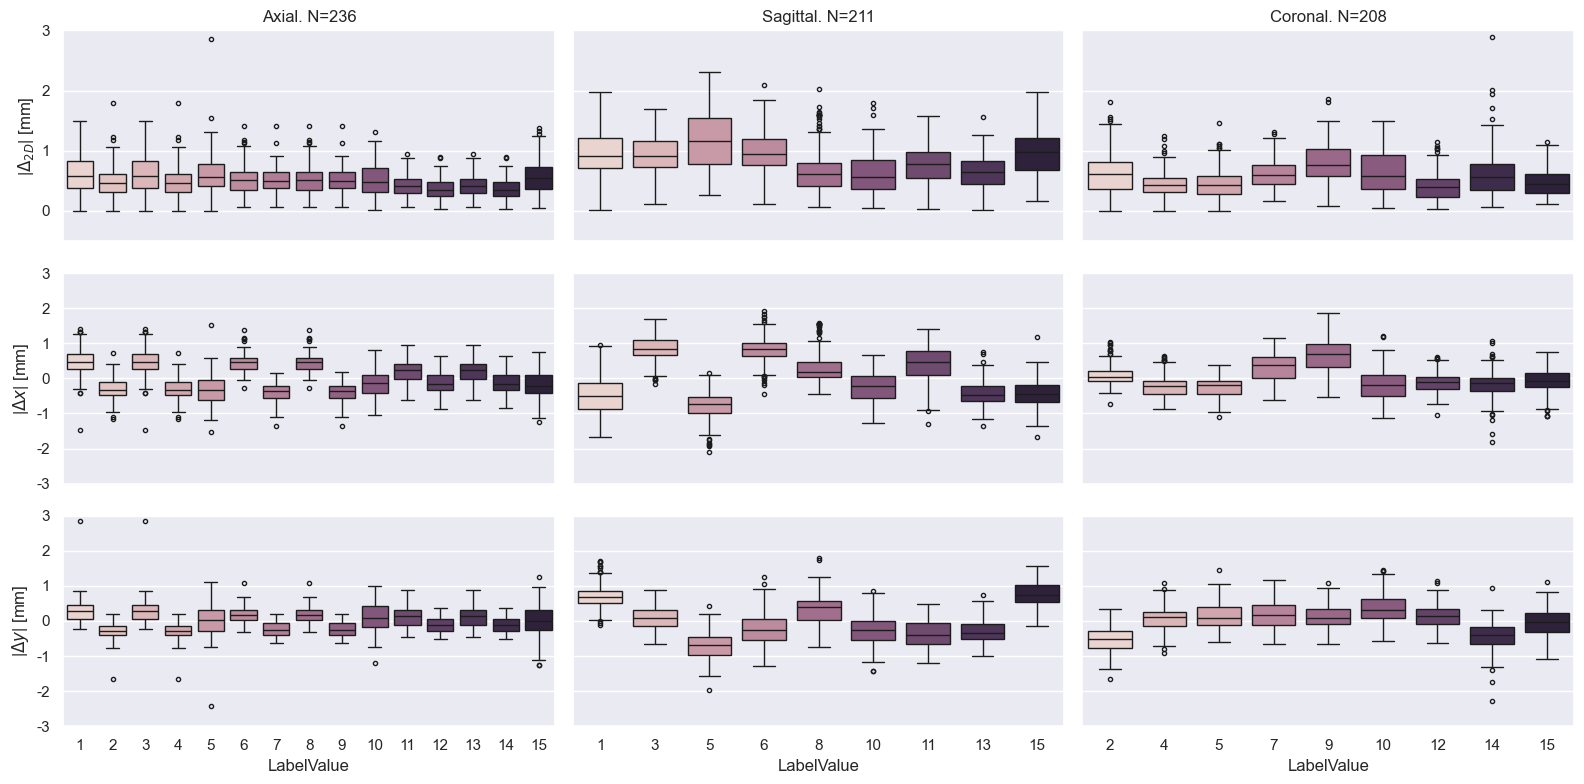

In [17]:
fig, axes = plt.subplots(3,3,figsize=(16,8))

titles = ['Axial', 'Sagittal', 'Coronal']
for i,scan_ax in enumerate(['axi', 'sag', 'cor']):
    sns.boxplot(data=df[(df['Axis']==scan_ax) & (df['Run']==1)], y='MagDiff', 
                x='LabelValue',  hue='LabelValue', legend=None, ax=axes[0,i], flierprops={"marker": "."})

    axes[0,i].set_ylim([-.5,3])
    nscans = df[(df['Axis']==scan_ax) & (df['Run']==1)].Session.unique().shape[-1]
    axes[0,i].set_title(f"{titles[i]}. N={nscans}")
    axes[0,i].set_xlabel(None)
    axes[0,i].set_xticklabels([])

    if i>0:
        axes[0,i].set_ylabel(None)
        axes[0,i].set_yticks([0,1,2,3], [])
    else:
        axes[0,i].set_yticks([0,1,2,3], [0,1,2,3])

for i,scan_ax in enumerate(['axi', 'sag', 'cor']):
    
    if scan_ax == 'axi':
        y = ['x_diff', 'y_diff']
    if scan_ax == 'sag':
        y = ['y_diff', 'z_diff']
    if scan_ax == 'cor':
        y = ['x_diff', 'z_diff']
    
    for k in range(2):
        sns.boxplot(data=df[(df['Axis']==scan_ax) & (df['Run']==1)], y='' + y[k], 
                    x='LabelValue',  hue='LabelValue', legend=None, ax=axes[k+1,i], flierprops={"marker": "."})
        
        axes[k+1,i].set_ylim([-3,3])

        if k==0:
            axes[k+1,i].set_xlabel(None)
            axes[k+1,i].set_xticklabels([])
        
        if i>0:
            axes[k+1,i].set_ylabel(None)
            axes[k+1,i].set_yticks([-3,-2,-1,0,1,2,3], [])
        else:
            axes[k+1,i].set_yticks([-3,-2,-1,0,1,2,3], [-3,-2,-1,0,1,2,3])
    
axes[0,0].set_ylabel(r'|$\Delta_{2D}$| [mm]')
axes[1,0].set_ylabel(r'|$\Delta x$| [mm]')
axes[2,0].set_ylabel(r'|$\Delta y$| [mm]')

plt.tight_layout()
plt.show()

## Distortions and bandwidth

Frequency encoding axes:

- Axi: x
- Sag: y
- Cor: z

In [184]:
df

,LabelValue,x_org,y_org,z_org,x_ref,y_ref,z_ref,x_reg,y_reg,z_reg,x_diff,y_diff,z_diff,Axis,Run,Subject,Session,Method,BW
39,1.0,-7.765591,-61.845161,53.597685,0.0,50.0,50.0,-0.403479,49.525955,47.825108,0.403479,0.474045,2.174892,sag,1,P0003,20230927164642,UNetRigid,0.002125
40,2.0,42.117025,-13.530755,57.974573,-50.0,0.0,50.0,-50.387642,1.196997,50.583710,0.387642,-1.196997,-0.583710,sag,1,P0003,20230927164642,UNetRigid,0.002125
41,3.0,-8.668909,38.969861,53.661845,0.0,-50.0,50.0,0.538379,-51.288246,48.141117,-0.538379,1.288246,1.858883,sag,1,P0003,20230927164642,UNetRigid,0.002125
42,4.0,-58.168967,-12.700036,52.939485,50.0,0.0,50.0,50.012711,0.403961,49.014301,-0.012711,-0.403961,0.985699,sag,1,P0003,20230927164642,UNetRigid,0.002125
43,5.0,-8.048685,-12.434335,54.675911,0.0,0.0,50.0,-0.137526,0.117734,49.020630,0.137526,-0.117734,0.979370,sag,1,P0003,20230927164642,UNetRigid,0.002125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52789,11.0,-7.791086,-64.224802,-46.804285,0.0,50.0,-50.0,2.065763,52.863045,-51.384258,-2.065763,-2.863045,1.384258,axi,2,P0039,20240207083415,UNetRigid,0.00175
52790,12.0,44.620407,-11.977814,-45.176947,-50.0,0.0,-50.0,-50.165874,0.411735,-51.104439,0.165874,-0.411735,1.104439,axi,2,P0039,20240207083415,UNetRigid,0.00175
52791,13.0,-4.354637,40.433951,-43.769315,0.0,-50.0,-50.0,-1.019356,-51.833870,-49.508144,1.019356,1.833870,-0.491856,axi,2,P0039,20240207083415,UNetRigid,0.00175
52792,14.0,-56.616646,-11.713108,-45.426069,50.0,0.0,-50.0,51.063641,0.517292,-49.820705,-1.063641,-0.517292,-0.179295,axi,2,P0039,20240207083415,UNetRigid,0.00175


In [171]:
df = pd.read_csv('../data/distortions_df.csv', low_memory=False)
df = df[df['Method']=='UNetRigid']
df.drop(df[(df['Subject'] == 'P0020') & (df['Session'] == '20240419161029')].index, inplace=True)

In [172]:
bw = {'axi':571.429,'cor':516.129,'sag':470.588}
FE = {'axi':136,'cor':124, 'sag':124}
df.loc[:,'BW'] = ''
for ax in bw.keys():
    df.loc[df['Axis']==ax,'BW'] = 1/bw[ax]

In [224]:
def get_dx_axis(df, sub, ses, label_val):
    my_df = df[(df['Session']==ses) & (df['Subject']==sub) & (df['Run']==1) & (df['LabelValue']==label_val)]
    
    # The dataframe should be 3 lines
    if len(my_df) != 3:
        print(my_df)
        raise ValueError("The dataframe does not have size=3")
    
    # Frequency
    ax_map = {'axi':'x', 'sag':'y', 'cor':'z'}
    
    # Phase
    ax_map = {'cor':'x', 'axi':'y', 'sag':'z'}

    x = []
    y = []
    for ax in ['axi', 'cor', 'sag']:
        x.append(my_df[my_df['Axis']==ax].BW.values[0])
        y.append(my_df[my_df['Axis']==ax][f'{ax_map[ax]}_diff'].values[0])

    return x, y        

In [225]:
all_sub = df['Subject'].unique()
all_ses = {}
for sub in all_sub:
    all_ses[sub] = list(df[df['Subject']==sub].Session.unique())

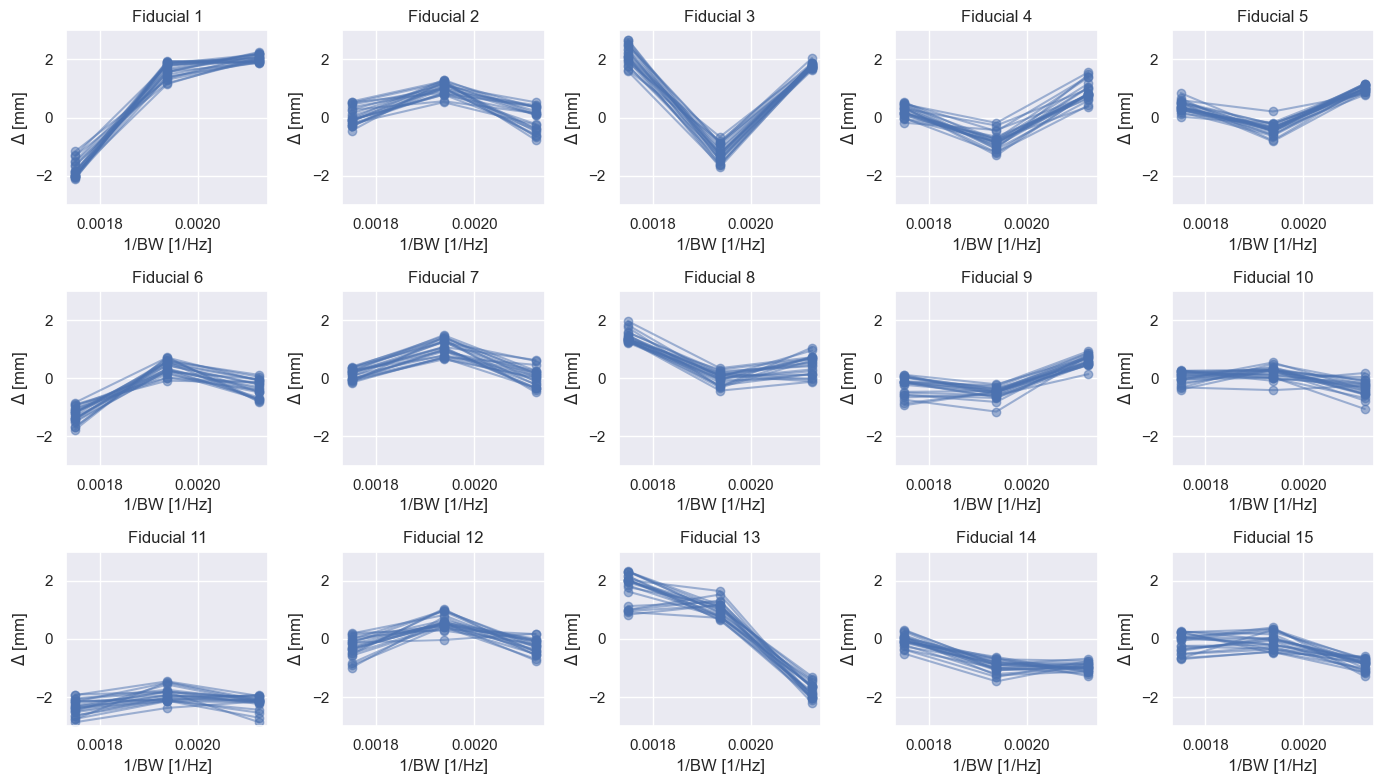

In [226]:

fig, axes = plt.subplots(3,5,figsize=(14,8))
sub = all_sub[0]
for k in range(len(all_ses[sub])):
    for i in range(15):
        ax = axes[np.unravel_index(i, axes.shape)]
        ses = all_ses[sub][k]
        x, y = get_dx_axis(df, sub, ses, i+1)
        
        ax.plot(x,y, 'o-', color=f'C00', alpha=0.5)

        ax.set_ylim([-3,3])
        ax.set_title(f'Fiducial {i+1}')
        ax.set_ylabel(r'$\Delta$ [mm]')
        ax.set_xlabel(r'1/BW [1/Hz]')


plt.tight_layout()


In [207]:
# Difference plots instead
df[(df['Session']==ses) & (df['Subject']==sub) & (df['Axis']=='axi')]

,LabelValue,x_org,y_org,z_org,x_ref,y_ref,z_ref,x_reg,y_reg,z_reg,x_diff,y_diff,z_diff,Axis,Run,Subject,Session,Method,BW
153,1.0,-5.733764,-64.477814,55.252623,0.0,50.0,50.0,-1.470996,52.073219,49.550682,1.470996,-2.073219,0.449318,axi,1,P0003,20230927164642,UNetRigid,0.00175
154,2.0,43.319253,-12.565443,57.469610,-50.0,0.0,50.0,-50.701824,0.294241,50.678070,0.701824,-0.294241,-0.678070,axi,1,P0003,20230927164642,UNetRigid,0.00175
155,3.0,-8.783122,39.177359,56.814998,0.0,-50.0,50.0,1.259544,-51.593803,50.902325,-1.259544,1.593803,-0.902325,axi,1,P0003,20230927164642,UNetRigid,0.00175
156,4.0,-57.752567,-12.245671,55.067677,50.0,0.0,50.0,50.396324,-0.305125,50.241615,-0.396324,0.305125,-0.241615,axi,1,P0003,20230927164642,UNetRigid,0.00175
157,5.0,-7.698068,-11.871931,56.551807,0.0,0.0,50.0,0.321574,-0.541148,50.750927,-0.321574,0.541148,-0.750927,axi,1,P0003,20230927164642,UNetRigid,0.00175
158,6.0,-5.931895,-63.548466,5.364376,0.0,50.0,0.0,-0.304796,51.270428,-0.326530,0.304796,-1.270428,0.326530,axi,1,P0003,20230927164642,UNetRigid,0.00175
159,7.0,44.465891,-11.960167,7.322787,-50.0,0.0,0.0,-50.874207,-0.180017,0.517016,0.874207,0.180017,-0.517016,axi,1,P0003,20230927164642,UNetRigid,0.00175
160,8.0,-5.760753,39.022186,7.229199,0.0,-50.0,0.0,-0.797005,-51.303749,1.267685,0.797005,1.303749,-1.267685,axi,1,P0003,20230927164642,UNetRigid,0.00175
161,9.0,-56.391535,-13.156385,4.894489,50.0,0.0,0.0,50.014317,0.737267,0.053980,-0.014317,-0.737267,-0.053980,axi,1,P0003,20230927164642,UNetRigid,0.00175
162,10.0,-6.764508,-12.152232,5.819841,0.0,0.0,0.0,0.376078,-0.128946,0.011292,-0.376078,0.128946,-0.011292,axi,1,P0003,20230927164642,UNetRigid,0.00175


In [215]:
def get_fid_diff(df, sub, ses, axis, l1, l2, d_ax):
    df_ax = df[(df['Session']==ses) & (df['Subject']==sub) & (df['Axis']==axis) & (df['Run']==1)]
    
    d = df_ax[df_ax['LabelValue']==l1][f'{d_ax}_org'].values[0] - df_ax[df_ax['LabelValue']==l2][f'{d_ax}_org'].values[0]
    return d

In [223]:
sub = all_sub[0]
ses = all_ses[sub][0]
print(get_fid_diff(df, sub, ses, 'axi', 9, 10, 'x'))
print(get_fid_diff(df, sub, ses, 'axi', 7, 10, 'x'))

-49.627027375249426
51.23039940844845
